### Import Python libraries

In [70]:
# Import the standard Python Data Science libraries for data processing and visualization
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp   

# Import the H2O AutoML libraries
import h2o
from h2o.automl import H2OAutoML

# Import label encoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

# Define how many base models will be built for stacking ensemble
max_models=201 # 201 is the winning model count

from scipy.stats import skew
from matplotlib import pyplot
from scipy.stats import boxcox
from numpy import exp
from math import sqrt
import shap 
# For timeseries analysis
import fbprophet

# Import libraries for various types of algorithms and metrics
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn import metrics
import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Import a train/test set into H2O
# These libraries are needed only when running this notebook on Azure ML cloud
# from azureml.core import Workspace, Datastore, Dataset

#### Instantiate H2O server

In [2]:
# Attempts to start and/or connect to and H2O instance
# max_mem_size - A character string specifying the maximum size, in bytes, of the memory allocation pool to H2O. This value must a multiple of 1024 greater than 2MB. 
# Append the letter m or M to indicate megabytes, or g or G to indicate gigabytes. 
# nthreads - Number of threads in the thread pool. This relates very closely to the number of CPUs used. -1 means use all CPUs on the host (Default). A positive integer specifies the number of CPUs directly. 
# This value is only used when R starts H2O.

h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=12  # in gigabytes
)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from C:\Users\SESA475934\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\SESA47~1\AppData\Local\Temp\tmph0mqdoy5
  JVM stdout: C:\Users\SESA47~1\AppData\Local\Temp\tmph0mqdoy5\h2o_SESA475934_started_from_python.out
  JVM stderr: C:\Users\SESA47~1\AppData\Local\Temp\tmph0mqdoy5\h2o_SESA475934_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_SESA475934_vgqr42
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10.66 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Import Train/Test data

In [3]:
# Import a train set into H2O
# Here, we import the training and testing datasets

train = h2o.import_file("C:\\Data_Science\\Competitions\\MachineHack-2021\\train.csv")
test = h2o.import_file("C:\\Data_Science\\Competitions\\MachineHack-2021\\test.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
# View the top 10 records in the training dataset

train.head(10)

Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
FDU32,21.0275,Baking Goods,197.352,OUT046,2004,Small,Tier 2,2689.46
NCT54,21.1024,Meat,148.25,OUT035,1987,Small,Tier 1,3437.35
FDW08,20.8823,Hard Drinks,205.465,OUT035,1999,Small,Tier 3,3129.97
FDJ22,21.0504,Starchy Foods,253.418,OUT046,1996,Small,Tier 1,1306.51
FDF47,21.2479,Baking Goods,240.871,OUT035,1988,Small,Tier 3,1739.77
DRK12,20.9564,Baking Goods,130.265,OUT049,1999,Small,Tier 1,1963.63
FDA32,21.1966,Breads,239.26,OUT035,1999,Small,Tier 2,581.888
FDH24,20.9493,Hard Drinks,167.267,OUT046,1997,Small,Tier 2,679.055
FDW03,20.8848,Baking Goods,185.454,OUT049,1997,Small,Tier 1,1991.32
FDE11,21.1836,Others,239.191,OUT018,2009,Small,Tier 1,730.149


In [5]:
# View the top 10 records in the testing dataset

test.head(10)

Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
DRM23,10.1567,Snack Foods,119.319,OUT013,1999,High,Tier 3
FDG47,10.4344,Household,263.6,OUT018,1987,High,Tier 3
FDN21,11.9536,Health and Hygiene,246.287,OUT018,1997,High,Tier 1
FDZ23,14.9485,Dairy,136.201,OUT046,2004,Medium,Tier 2
FDC16,11.08,Canned,173.146,OUT018,2009,Medium,Tier 3
NCE07,17.926,Snack Foods,170.716,OUT035,1999,High,Tier 1
FDH27,17.0159,Canned,129.429,OUT013,1987,Medium,Tier 1
FDL13,17.6679,Frozen Foods,117.019,OUT046,1996,Medium,Tier 3
NCX30,13.4279,Dairy,237.581,OUT049,1997,Medium,Tier 2
FDR35,12.4611,Health and Hygiene,138.914,OUT013,2009,High,Tier 3


In [6]:
#Convert H2O frame to Pandas dataframe(This is done so that data operations can be easily done)

train_as_df = h2o.as_list(train, use_pandas=True)
test_as_df = h2o.as_list(test, use_pandas=True)

### Exploratory Data Analysis

### Profile Report

    The pandas df.describe() function is great but a little basic for serious exploratory data analysis. pandas_profiling extends the pandas DataFrame with df.profile_report() for quick data analysis.

In [7]:
#pp.ProfileReport(credit_num)
profile=pp.ProfileReport(train_as_df, minimal=False, explorative=True)
profile
profile.to_file("C:\\Data_Science\\Competitions\\MachineHack-2021\\profile_report.html")

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Histogram

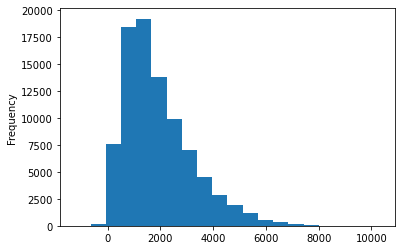

In [8]:
#Sales
train_as_df['Sales'].plot.hist(bins=20)

In [9]:
train_as_df.head(5)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


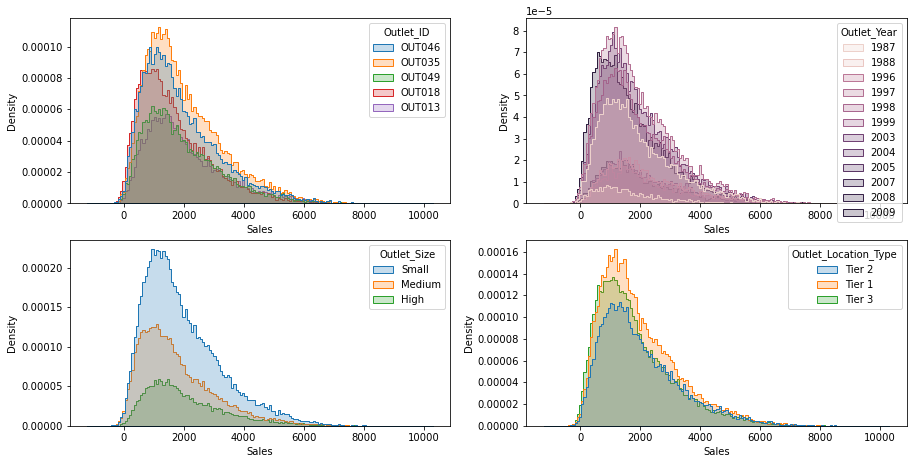

In [10]:
#Sales
fig, axs = plt.subplots(nrows = 2, ncols=2)
fig.set_size_inches(15, 7.5)

sns.histplot(train_as_df, x="Sales", hue="Outlet_ID", element="step",stat="density", ax=axs[0][0])
sns.histplot(train_as_df, x="Sales", hue="Outlet_Year", element="step",stat="density", ax=axs[0][1])
sns.histplot(train_as_df, x="Sales", hue="Outlet_Size", element="step", stat="density",ax=axs[1][0])
sns.histplot(train_as_df, x="Sales", hue="Outlet_Location_Type", element="step", stat="density",ax=axs[1][1])
#sns.histplot(train_as_df, x="Sales", hue="Item_Type", element="step", stat="density",ax=axs[4])

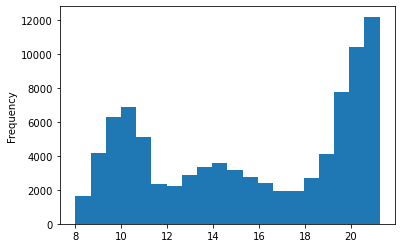

In [11]:
# Item Weight
train_as_df['Item_W'].plot.hist(bins=20)

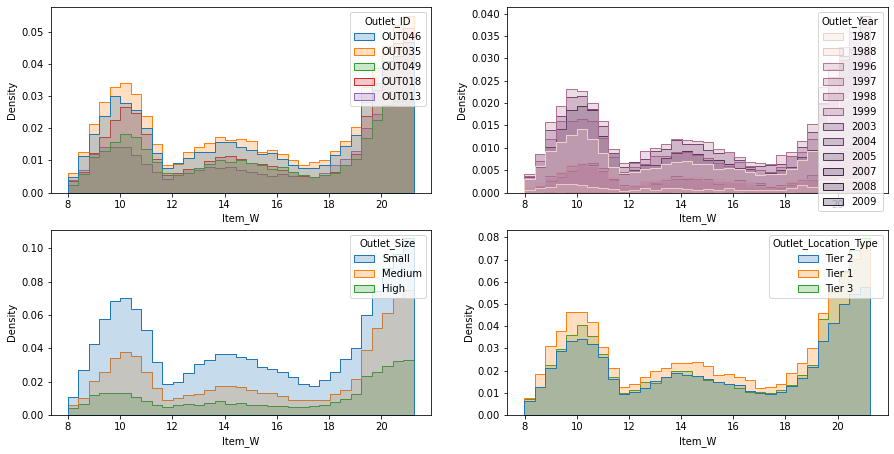

In [12]:
#Item Weight
fig, axs = plt.subplots(nrows = 2, ncols=2)
fig.set_size_inches(15, 7.5)

sns.histplot(train_as_df, x="Item_W", hue="Outlet_ID", element="step", stat="density",ax=axs[0][0])
sns.histplot(train_as_df, x="Item_W", hue="Outlet_Year", element="step", stat="density",ax=axs[0][1])
sns.histplot(train_as_df, x="Item_W", hue="Outlet_Size", element="step", stat="density",ax=axs[1][0])
sns.histplot(train_as_df, x="Item_W", hue="Outlet_Location_Type", element="step",stat="density", ax=axs[1][1])
#sns.histplot(train_as_df, x="Item_W", hue="Item_Type", element="step",stat="density", ax=axs[4])

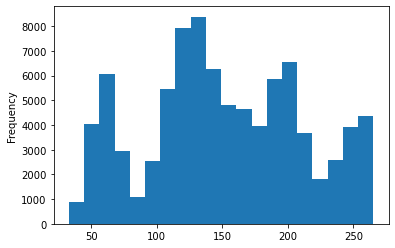

In [13]:
# Item MRP
train_as_df['Item_MRP'].plot.hist(bins=20)

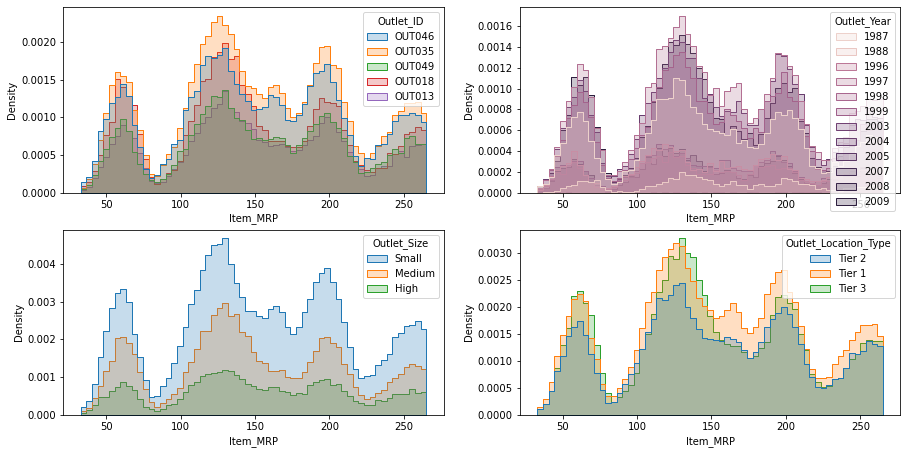

In [14]:
#Item MRP
fig, axs = plt.subplots(nrows = 2, ncols=2)
fig.set_size_inches(15, 7.5)

sns.histplot(train_as_df, x="Item_MRP", hue="Outlet_ID", element="step", stat="density",ax=axs[0][0])
sns.histplot(train_as_df, x="Item_MRP", hue="Outlet_Year", element="step", stat="density",ax=axs[0][1])
sns.histplot(train_as_df, x="Item_MRP", hue="Outlet_Size", element="step", stat="density",ax=axs[1][0])
sns.histplot(train_as_df, x="Item_MRP", hue="Outlet_Location_Type", element="step",stat="density", ax=axs[1][1])
#sns.histplot(train_as_df, x="Item_MRP", hue="Item_Type", element="step",stat="density", ax=axs[4])

### Box Plot

In [15]:
def annotate_boxplot(ax,size):
    lines = ax.get_lines()
    categories = ax.get_xticks()
    for cat in categories:
        # every 4th line at the interval of 6 is median line
        # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
        y = round(lines[4+cat*6].get_ydata()[0],1) 
        ax.text(
            cat, 
            y, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=size,
            color='white',
            bbox=dict(facecolor='#445A64'))
    plt.tight_layout()

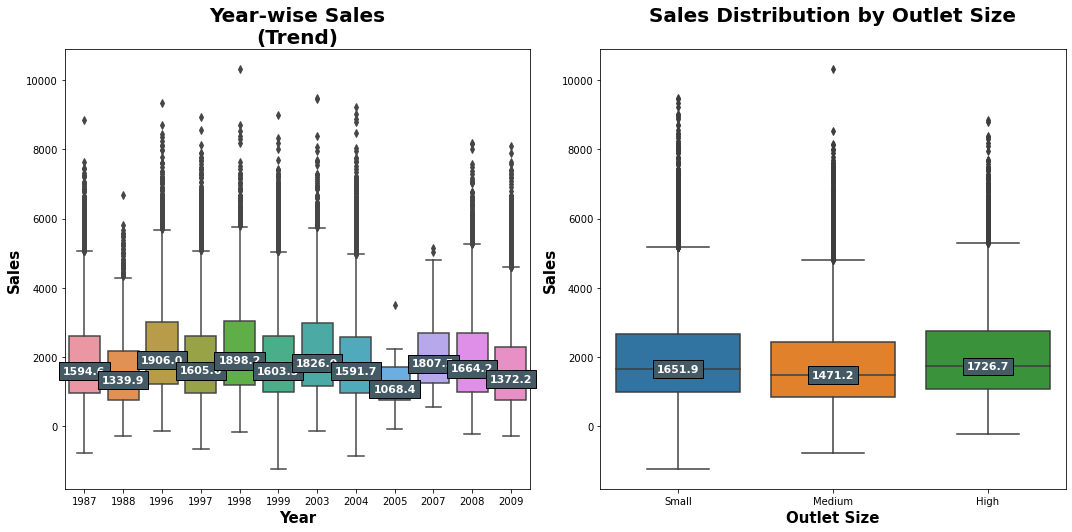

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
fig.set_size_inches(15, 7.5)

sns.boxplot(x="Outlet_Year",y="Sales",data=train_as_df, ax=ax[0])
ax[0].set_title('Year-wise Sales\n(Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 15, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Sales', fontsize = 15, fontdict=dict(weight='bold'))
annotate_boxplot(ax[0],11)

sns.boxplot(x="Outlet_Size",y="Sales",data=train_as_df, ax=ax[1])
ax[1].set_title('Sales Distribution by Outlet Size\n', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Outlet Size', fontsize = 15, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Sales', fontsize = 15, fontdict=dict(weight='bold'))
annotate_boxplot(ax[1],11)

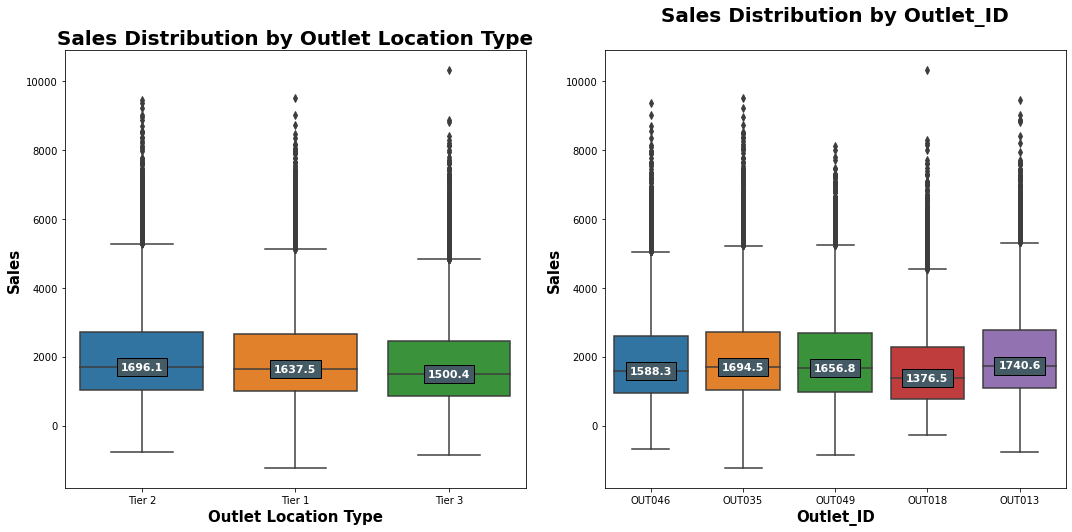

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
fig.set_size_inches(15, 7.5)

sns.boxplot(x="Outlet_Location_Type",y="Sales",data=train_as_df, ax=ax[0])
ax[0].set_title('Sales Distribution by Outlet Location Type', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Outlet Location Type', fontsize = 15, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Sales', fontsize = 15, fontdict=dict(weight='bold'))
annotate_boxplot(ax[0],11)

sns.boxplot(x="Outlet_ID",y="Sales",data=train_as_df, ax=ax[1])
ax[1].set_title('Sales Distribution by Outlet_ID\n', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Outlet_ID', fontsize = 15, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Sales', fontsize = 15, fontdict=dict(weight='bold'))
annotate_boxplot(ax[1],11)

### Time Series Analysis

C:\Users\SESA475934\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([1985., 1990., 1995., 2000., 2005., 2010., 2015.]),
 <a list of 7 Text major ticklabel objects>)

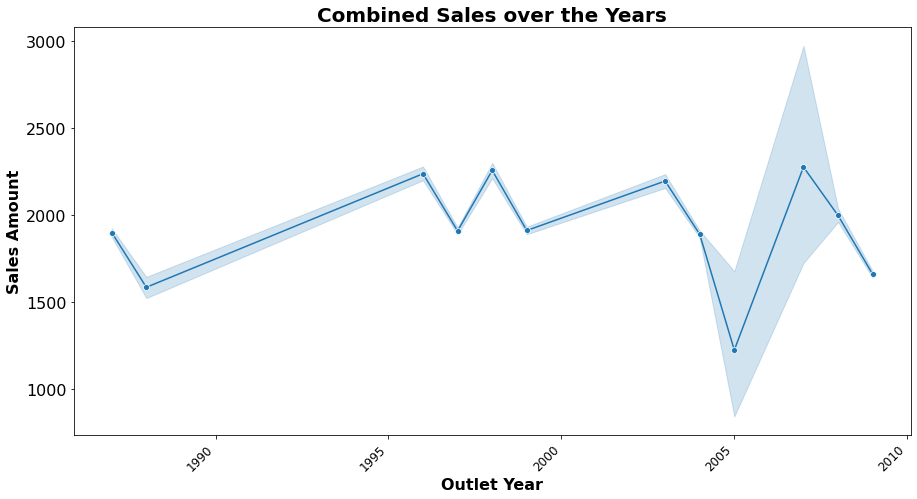

In [18]:
# Timeseries plotting using Seaborn library

fig, ax = plt.subplots(figsize=(15, 7.5))
d = train_as_df
sns.lineplot(d['Outlet_Year'], d['Sales'], marker="o") 

ax.set_title('Combined Sales over the Years', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Outlet Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Sales Amount', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)


C:\Users\SESA475934\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


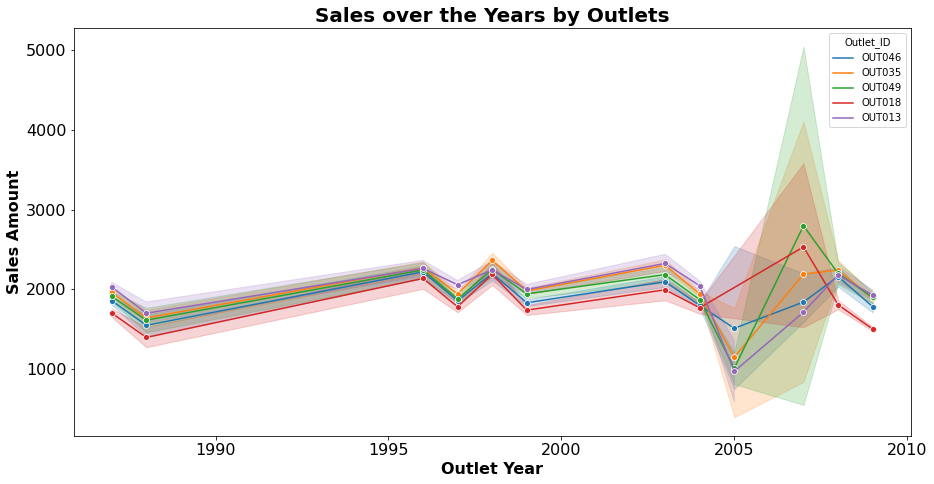

In [19]:
# Timeseries plotting using Seaborn library
# Sales Distribution over the years as per Outlet ID
# Sales Distribution by Outlet ID

fig, ax = plt.subplots(figsize=(15, 7.5))
d = train_as_df
sns.lineplot(d['Outlet_Year'], d['Sales'], marker="o", hue=d["Outlet_ID"]) 

ax.set_title('Sales over the Years by Outlets', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Outlet Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Sales Amount', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)


C:\Users\SESA475934\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


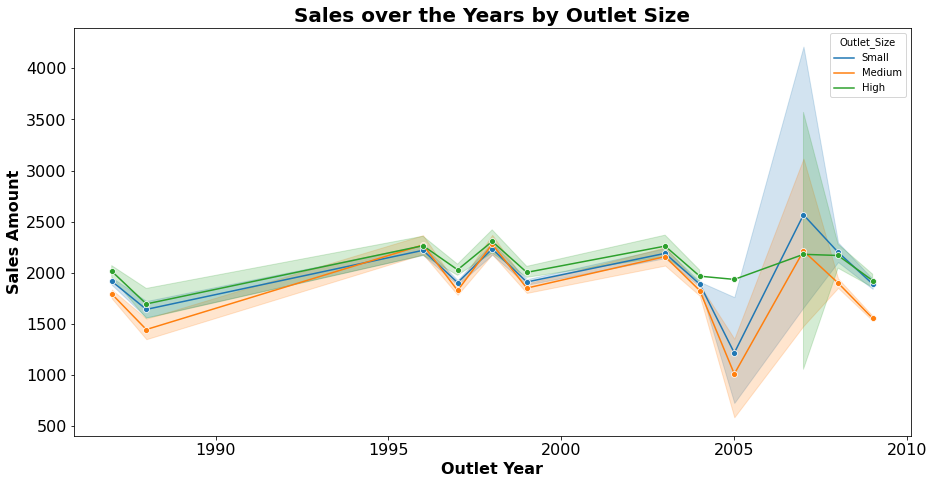

In [20]:
# Timeseries plotting using Seaborn library
# Sales Distribution over the years as per Outlet ID
# Sales Distribution by Outlet_Size

fig, ax = plt.subplots(figsize=(15, 7.5))
d = train_as_df
sns.lineplot(d['Outlet_Year'], d['Sales'], marker="o", hue=d["Outlet_Size"]) 

ax.set_title('Sales over the Years by Outlet Size', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Outlet Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Sales Amount', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

C:\Users\SESA475934\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


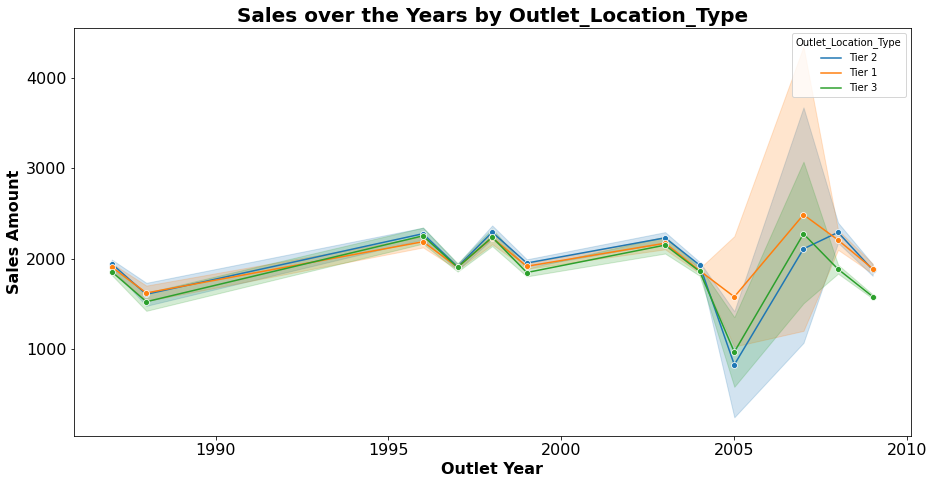

In [21]:
# Timeseries plotting using Seaborn library
# Sales Distribution over the years as per Outlet ID
# Sales Distribution by Outlet_Location_Type

fig, ax = plt.subplots(figsize=(15, 7.5))
d = train_as_df
sns.lineplot(d['Outlet_Year'], d['Sales'], marker="o", hue=d["Outlet_Location_Type"]) 

ax.set_title('Sales over the Years by Outlet_Location_Type', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Outlet Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Sales Amount', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

C:\Users\SESA475934\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


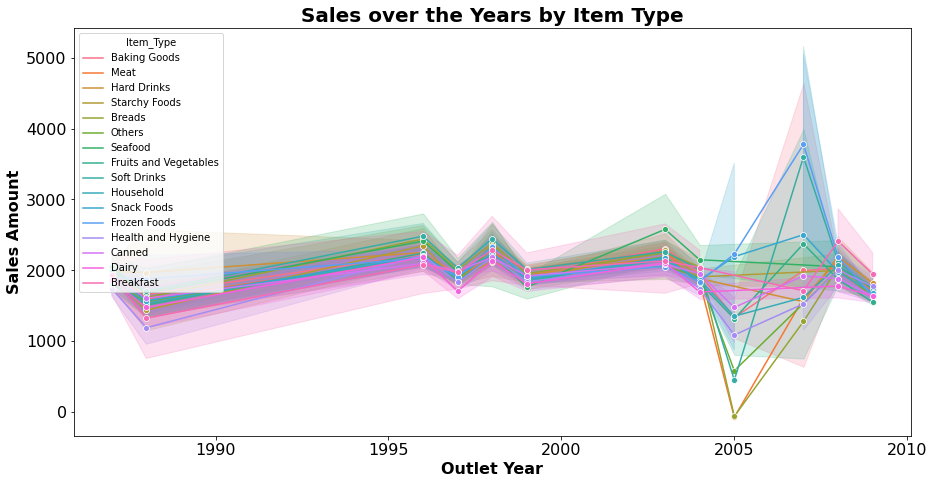

In [22]:
# Timeseries plotting using Seaborn library
# Sales Distribution over the years as per Outlet ID
# Sales Distribution by Outlet_Size

fig, ax = plt.subplots(figsize=(15, 7.5))
d = train_as_df
sns.lineplot(d['Outlet_Year'], d['Sales'], marker="o", hue=d["Item_Type"]) 

ax.set_title('Sales over the Years by Item Type', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Outlet Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Sales Amount', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

### Time Series Modelling - Prophet

In [23]:
# Create a timeseries dataframe with Year and Sales fields
# We will do time series modelling using Prophet algorithm from Facebook

train_as_ts = train_as_df[['Outlet_Year','Sales']].copy() 
train_as_ts['Outlet_Year'] = pd.to_datetime(train_as_ts['Outlet_Year'], format='%Y') # Since field has only got year value

# Prophet requires columns in this format: ds (Date) and y (value)
train_as_ts = train_as_ts.rename(columns={'Outlet_Year': 'ds', 'Sales': 'y'})

# Build the prophet model and fit on the training data
prophet_model = fbprophet.Prophet(changepoint_prior_scale=0.15)
prophet_model.fit(train_as_ts) 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


When creating the prophet models, I set the changepoint prior to 0.15, up from the default value of 0.05. This hyperparameter is used to control how sensitive the trend is to changes, with a higher value being more sensitive and a lower value less sensitive. This value is used to combat one of the most fundamental trade-offs in machine learning: bias vs. variance

In [24]:
# Make a future dataframe for 5 years
forecast = prophet_model.make_future_dataframe(periods=5, freq='Y')
# Make Sales predictions for next 5 years 
df_forecast = prophet_model.predict(forecast)

Here, under the predictions table, we are only concerned with ds, yhat_lower, yhat_upper, and yhat because these are the variables that will give us the predicted results with respect to the date specified.

yhat means the predicted output based on the input fed to the model, yhat_lower, and upper means the upper and lower value that can go based on the predicted output that is, the fluctuations that can happen

In [25]:
# Check the sales forecast for 5 years from 2009-2013

df_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
12,2009-12-31,2072.633811,485.343255,3727.218198
13,2010-12-31,2110.813697,398.771541,3807.033989
14,2011-12-31,2146.334319,401.683036,3943.174761
15,2012-12-31,1847.171606,-73.918195,3697.765366
16,2013-12-31,1887.913505,-144.447900,3917.335528


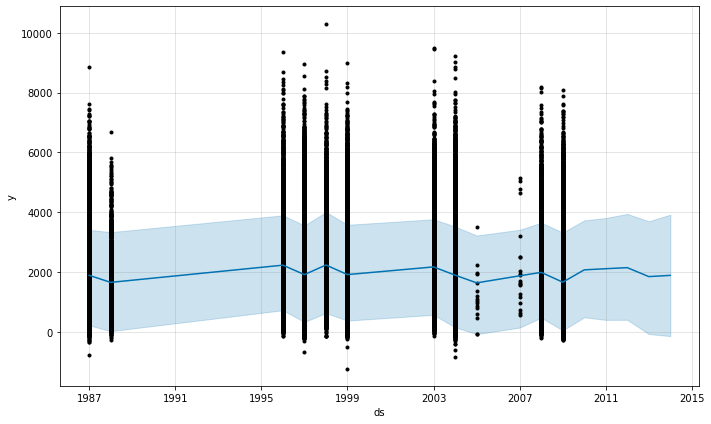

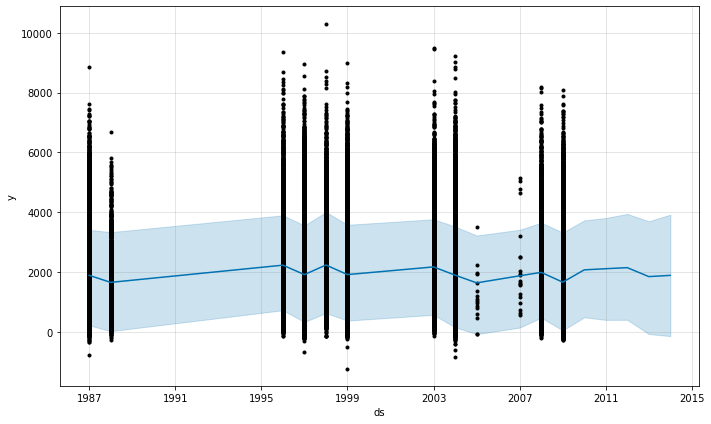

In [26]:
#Plot the output timeseries

prophet_model.plot(df_forecast)

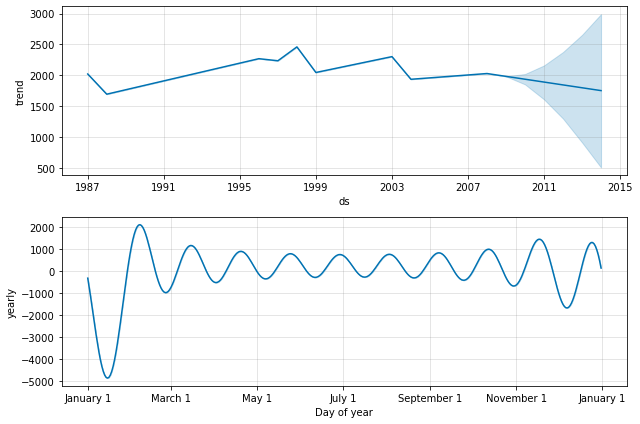

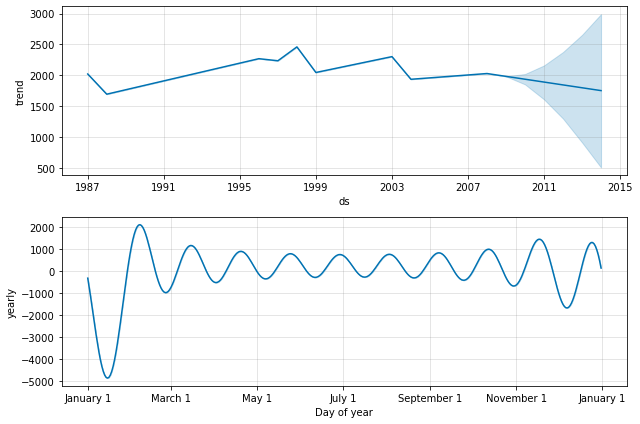

In [27]:
#Checking the trends in the data

prophet_model.plot_components(df_forecast)

Above we can see the trends with respect to year and cyclicity in a year. The first graph represents an slightly decreasing trend as we progress through the years and the latter shows a fluctuating trend in the monthly sales. 
For most months it is steady but towards the end of the year from December to January there is some fluctuation.
The fluctuation gains momemtum between January and February.

### Statistical Analysis

### Check Skewness or Normality Distribution


Skewness for Item_MRP :  0.055660346208835934


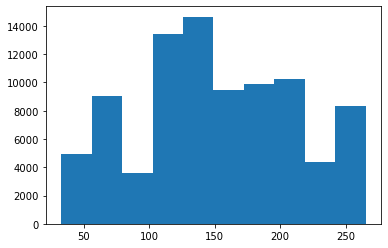


Skewness for Item_W :  -0.17953093828329283


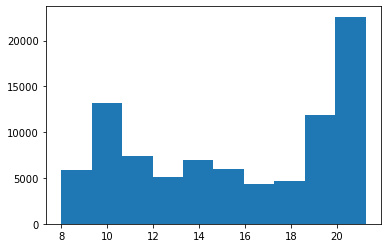

In [28]:
# For Item_W and Item_MRP features, lets checks their skewness. Skewness is a measure of symmetry in a distribution. Actually, it’s more correct to describe it as a measure of lack of symmetry. 
# A standard normal distribution is perfectly symmetrical and has zero skew. 

data = train_as_df['Item_MRP']
print( '\nSkewness for Item_MRP : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()

data = train_as_df['Item_W']
print( '\nSkewness for Item_W : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()

### Handle -ve Sales values

In [29]:
# We find there are sone -ve sales values which is not clear.
# Negative sales number might mean that these are losses , however this is not clerly degined in the problem statement
# First, we try by dropping the -ve sales records but its leads to reduced RMSE values
# Finally, we found that by turning these -ve numbers to positive , we can get a marginally better RMSE 

cols = 'Sales'
negative_sales = train_as_df[train_as_df[cols] < 0]
negative_sales
#train = train[train[cols] >= 0] 
# Convert to absolute values of sales
train_as_df['Sales'] = train_as_df['Sales'].abs()

### Outlier Detection


Skewness for Sales :  1.1313029228390308


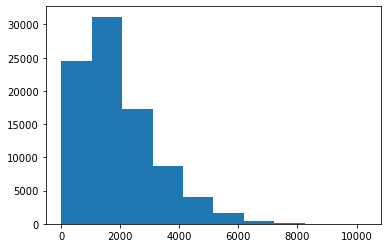

Text(0.5, 0, 'Sample')

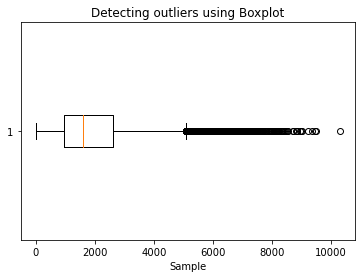

In [30]:
# Outlier Detection in 'Sales'
# After handling outliers in Sales, check the skewness and normality again - it should improve

data = train_as_df['Sales']
print( '\nSkewness for Sales : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()

plt.boxplot(data, vert=False)
plt.title("Detecting outliers using Boxplot")
plt.xlabel('Sample')

### IQR method of outlier detection

    Calculate the interquartile range for the data.
    Multiply the interquartile range (IQR) by 1.5 (a constant used to discern outliers).
    Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier.
    Subtract 1.5 x (IQR) from the first quartile. Any number less than this is a suspected outlier.

In [31]:
# Find the outlier datapoints in 'Sales'

# finding the 1st quartile
q1 = np.quantile(train_as_df['Sales'], 0.25)
 
# finding the 3rd quartile
q3 = np.quantile(train_as_df['Sales'], 0.75)
med = np.median(train_as_df['Sales'])
print(med)
 
# finding the iqr region
iqr = q3-q1

print('Median', med)

# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

outliers = train_as_df[(train_as_df['Sales'] <= lower_bound) | (train_as_df['Sales'] >= upper_bound)].Sales
print('The following are the outliers in the boxplot:{}'.format(outliers))

1606.3078770000002
Median 1606.3078770000002
1648.6986815750004 5081.105758612501 -1513.6889676875005
The following are the outliers in the boxplot:13       6379.790499
30       6741.017116
33       6198.371937
228      5794.834611
246      8699.342857
            ...     
87746    5145.665334
87752    5392.408338
87762    6243.916532
87791    5896.324800
87833    6079.419800
Name: Sales, Length: 2378, dtype: float64


### Outlier Handling by Winsorization

Winsorization is a way to minimize the influence of outliers in your data by either:
    Assigning the outlier a lower weight
    Changing the value so that it is close to other values in the set

The data points are modified, not trimmed/removed

In [32]:
# Handle outliers by replacing values above/below a certain threhold with the threshold
# here, we have taken the lower and upper thresholds to be 1% and 99%
# Winsorization: Percentile based flooring and capping
removeOutlier = '0' # 0 means don't exclude outliers, this is just a flag for trying with/without outlier handling

df=train_as_df
col='Sales'
for col in df:
    #get dtype for column
    dt = df[col].dtype 
    #check if we want to handle outliers?
    if removeOutlier == '1':
        #check if it is a numbers
        if dt == 'int64' or dt == 'float64':
            df[col]=df[col].clip(upper = (df[col].quantile(0.99))) 
            df[col]=df[col].clip(lower = (df[col].quantile(0.01)))

### Feature Engineering

In [33]:
# Create a new field Item_Group based on Item_Type
# Here, we notice that Item-Type values can be grouped into some common categories of data like Drinks, Non Cosummables and Food
# Creating these new features help us better train the model in later stage

# we create a list of our IF...ELSE conditions for training data
conditions = [
    (train_as_df['Item_Type'] == 'Hard Drinks') | (train_as_df['Item_Type'] == 'Soft Drinks'),
    (train_as_df['Item_Type'] == 'Others') | (train_as_df['Item_Type'] == 'Household') | (train_as_df['Item_Type'] == 'Health and Hygiene'),
    (train_as_df['Item_Type'] == 'Baking Goods') | (train_as_df['Item_Type'] == 'Meat') | (train_as_df['Item_Type'] == 'Starchy Foods') | (train_as_df['Item_Type'] == 'Breads') | (train_as_df['Item_Type'] == 'Seafood'),
    (train_as_df['Item_Type'] == 'Fruits and Vegetables') | (train_as_df['Item_Type'] == 'Breakfast') | (train_as_df['Item_Type'] == 'Snack Foods') | (train_as_df['Item_Type'] == 'Frozen Foods') | (train_as_df['Item_Type'] == 'Canned') | (train_as_df['Item_Type'] == 'Dairy')
    ]

# create a list of the values we want to assign for each condition in train
values = ['Drinks', 'Non_Consummables', 'Food', 'Food']

# we create a list of our IF...ELSE conditions for testing data
conditions_t = [
    (test_as_df['Item_Type'] == 'Hard Drinks') | (test_as_df['Item_Type'] == 'Soft Drinks'),
    (test_as_df['Item_Type'] == 'Others') | (test_as_df['Item_Type'] == 'Household') | (test_as_df['Item_Type'] == 'Health and Hygiene'),
    (test_as_df['Item_Type'] == 'Baking Goods') | (test_as_df['Item_Type'] == 'Meat') | (test_as_df['Item_Type'] == 'Starchy Foods') | (test_as_df['Item_Type'] == 'Breads') | (test_as_df['Item_Type'] == 'Seafood'),
    (test_as_df['Item_Type'] == 'Fruits and Vegetables') | (test_as_df['Item_Type'] == 'Breakfast') | (test_as_df['Item_Type'] == 'Snack Foods') | (test_as_df['Item_Type'] == 'Frozen Foods') | (test_as_df['Item_Type'] == 'Canned') | (test_as_df['Item_Type'] == 'Dairy')
    ]

# create a list of the values we want to assign for each condition in test
values_t = ['Drinks', 'Non_Consummables', 'Food', 'Food']

In [34]:
# we create Item_Group based on the conditions defined above

train_as_df['Item_Group'] = np.select(conditions, values)
test_as_df['Item_Group'] = np.select(conditions_t, values_t)

In [35]:
#Derive the Outlet_Age column

# In the given dataset, we have a feayure called Outlet_Year but this by itself is not going to be very useful
# We know that the age of an outlet can have some impact on the sales, an older more well known outlet might have more sales than a newer one

train_as_df['Outlet_Age'] = 2021 - train_as_df['Outlet_Year']
train_as_df=train_as_df.drop(['Outlet_Year'], axis = 1)

test_as_df['Outlet_Age'] = 2021 - test_as_df['Outlet_Year']
test_as_df=test_as_df.drop(['Outlet_Year'], axis = 1)

In [36]:
# So far we should not get any NA values, still better to check
#Check for any missing values - train

round((train_as_df.isnull().sum() * 100/ len(train_as_df)),2).sort_values(ascending=False)

Outlet_Age              0.0
Item_Group              0.0
Sales                   0.0
Outlet_Location_Type    0.0
Outlet_Size             0.0
Outlet_ID               0.0
Item_MRP                0.0
Item_Type               0.0
Item_W                  0.0
Item_ID                 0.0
dtype: float64

In [37]:
#Check for any missing values - test

round((test_as_df.isnull().sum() * 100/ len(test_as_df)),2).sort_values(ascending=False)

Outlet_Age              0.0
Item_Group              0.0
Outlet_Location_Type    0.0
Outlet_Size             0.0
Outlet_ID               0.0
Item_MRP                0.0
Item_Type               0.0
Item_W                  0.0
Item_ID                 0.0
dtype: float64

In [38]:
# Break the item id into 2 columns item code and item number
# This step is no longer applied since it does not improve the RMSE

#train['Item_Code'] = [x[:3] for x in train['Item_ID']]
#train['Item_Number'] = train['Item_ID'].str[-2:]
#train = train.drop(['Item_ID'], axis = 1)

#test['Item_Code'] = [x[:3] for x in test['Item_ID']]
#test['Item_Number'] = test['Item_ID'].str[-2:]
#test = test.drop(['Item_ID'], axis = 1)
#
#Convert Item_Number to character and sppend a prefix
#train['Item_Number'] = '__' + train['Item_Number'].astype(str)
#test['Item_Number'] = '__' + test['Item_Number'].astype(str)

### Categorical to Numeric Conversion
Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric. Since we will be applying a regression algorithm, all the features must be numeric in nature.
We can do it by converting the existing categorical columns by applying:

    1. Label Encoding
    Here, each unique category value is assigned an integer value.We convert the labels into a numeric form so as to convert them into the machine-readable form.
    
    2. One Hot Encoding 
    For categorical variables where no ordinal relationship exists, the label encoding is not enough.
    In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor   performance or unexpected results (predictions halfway between categories).   


In [39]:
# One HOT Encoding
# Define a function that will take the original dataframe and features to encode as input, 'one-hot encode' the features and then return the dataframe to calling function.

def one_hot_encode(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    original_dataframe = pd.concat([original_dataframe, dummies], axis=1)
    original_dataframe=original_dataframe.drop([feature_to_encode], axis = 1)
    return(original_dataframe)

In [40]:
# Label Encoding
# Define a function that will take the original dataframe and features to encode as input, 'label encode' the features and then return the dataframe to calling function.

def label_encode(original_dataframe, feature_to_encode):
    # label_encoder object knows how to understand word labels.
    label_encoder = preprocessing.LabelEncoder()    
    # Encode labels in column 'species'.
    original_dataframe[feature_to_encode]= label_encoder.fit_transform(original_dataframe[feature_to_encode])  
    return(original_dataframe)

In [41]:
#Encode the training features

train_as_df = one_hot_encode(train_as_df, 'Item_Type')
train_as_df = label_encode(train_as_df, 'Outlet_Size')
train_as_df = label_encode(train_as_df, 'Outlet_Location_Type')
train_as_df = one_hot_encode(train_as_df, 'Outlet_ID')
#train_as_df = one_hot_encode(train_as_df, 'Item_Code')
#train_as_df = one_hot_encode(train_as_df, 'Item_Number')
train_as_df = one_hot_encode(train_as_df, 'Item_Group')
train_as_df = one_hot_encode(train_as_df, 'Item_ID')

In [42]:
train_as_df.head(5)

,Item_W,Item_MRP,Outlet_Size,Outlet_Location_Type,Sales,Outlet_Age,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_ID_NCY30,Item_ID_NCY42,Item_ID_NCY53,Item_ID_NCZ17,Item_ID_NCZ18,Item_ID_NCZ29,Item_ID_NCZ41,Item_ID_NCZ42,Item_ID_NCZ53,Item_ID_NCZ54
0,21.027499,197.352319,2,1,2689.457781,17,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21.102371,148.250214,2,0,3437.350375,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20.882263,205.465010,2,2,3129.967268,22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21.050435,253.417583,2,0,1306.514376,25,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21.247876,240.871039,2,2,1739.769829,33,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
#Encode the testing features

test_as_df = one_hot_encode(test_as_df, 'Item_Type')
test_as_df = label_encode(test_as_df, 'Outlet_Size')
test_as_df = label_encode(test_as_df, 'Outlet_Location_Type')
test_as_df = one_hot_encode(test_as_df, 'Outlet_ID')
#test_as_df = one_hot_encode(test_as_df, 'Item_Code')
#test_as_df = one_hot_encode(test_as_df, 'Item_Number')
test_as_df = one_hot_encode(test_as_df, 'Item_Group')
test_as_df = one_hot_encode(test_as_df, 'Item_ID')

In [44]:
test_as_df.head(5)

,Item_W,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Age,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Item_ID_NCY30,Item_ID_NCY42,Item_ID_NCY53,Item_ID_NCZ17,Item_ID_NCZ18,Item_ID_NCZ29,Item_ID_NCZ41,Item_ID_NCZ42,Item_ID_NCZ53,Item_ID_NCZ54
0,10.156725,119.319482,0,2,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.434425,263.600449,0,2,34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.953589,246.286990,0,0,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14.948546,136.200508,1,1,17,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,11.080042,173.145664,1,2,12,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Machine Learning Modelling

In [46]:
#Copy the train and test dataframes for the purpose of building Linear Regression model
#This is done because we will use the original dataframes for ensemble modelling at a later stage

train_as_df_LINREG = train_as_df.copy()
test_as_df_LINREG = test_as_df.copy()

In [47]:
#Splitting the data in 80:20 ratio

feature_columns = train_as_df_LINREG.columns.difference( ['Sales'] )
train_X, test_X, train_y, test_y = train_test_split(train_as_df_LINREG[feature_columns],
                                                  train_as_df_LINREG['Sales'],
                                                  test_size=0.20,
                                                  random_state=125)
print (len( train_X ))
print (len (train_y))
print (len( test_X))
print (len( test_y))
print (train_as_df_LINREG.shape)

70291
70291
17573
17573
(87864, 925)


### 1. Multivariate Linear Regression

Root Mean Squared Error:  1285.8384465908168
R2 Score:  -0.0013427901479490245


C:\Users\SESA475934\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\SESA475934\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


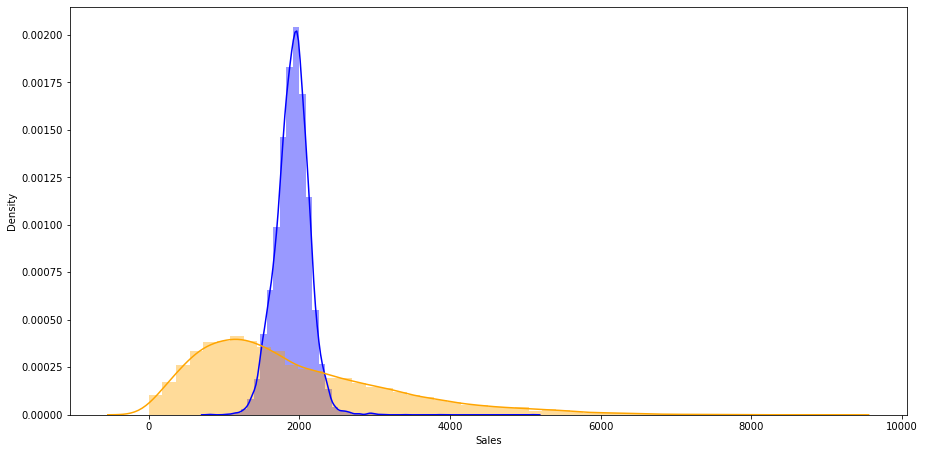

In [67]:
## Linear Regression 
# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(train_X, train_y)
# Predict
y_predicted = regression_model.predict(test_X)

# model evaluation
mse = mean_squared_error(test_y, y_predicted)
r2 = r2_score(test_y, y_predicted)

# printing values
#print('Slope:' ,regression_model.coef_)
#print('Intercept:', regression_model.intercept_)
print('Root Mean Squared Error: ', sqrt(mse)) 
print('R2 Score: ', r2)

#Plot actual vs predicted y values
y_pred=grid.predict(test_X)
plt.figure(figsize=(15,7.5))
sns.distplot(y_pred,color="Blue",label="Predicted")
sns.distplot(test_y,color="Orange",label="Actual")
plt.grid(False)

#Save the figure in a file
#plt.savefig(output_dir+"regression\\actual_predicted.png",bbox_inches='tight')    
plt.show() 
plt.close()

### 2. Random Forest Regressor

In [68]:
# Model initialization
clf_rf = RandomForestRegressor(n_estimators=100) # Tried with 100, 200 etc.
# Fit the data(train the model)
clf_rf.fit(train_X, train_y)
# Predict
y_predicted = clf_rf.predict(test_X)

# model evaluation
mse = mean_squared_error(test_y, y_predicted)
r2 = r2_score(test_y, y_predicted)

# printing values
#print('Slope:' ,regression_model.coef_)
#print('Intercept:', regression_model.intercept_)
print('Root Mean Squared Error: ', sqrt(mse))
print('R2 Score: ', r2)

#Plot actual vs predicted y values
y_pred=grid.predict(test_X)
plt.figure(figsize=(15,7.5))
sns.distplot(y_pred,color="Blue",label="Predicted")
sns.distplot(test_y,color="Orange",label="Actual")
plt.grid(False)

#Save the figure in a file
#plt.savefig(output_dir+"regression\\actual_predicted.png",bbox_inches='tight')    
plt.show() 
plt.close()

KeyboardInterrupt: 

### 3. XGBoost Regressor


Root Mean Squared Error:  1278.6059761544184
R2 Score:  0.009890058819441383


C:\Users\SESA475934\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\SESA475934\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


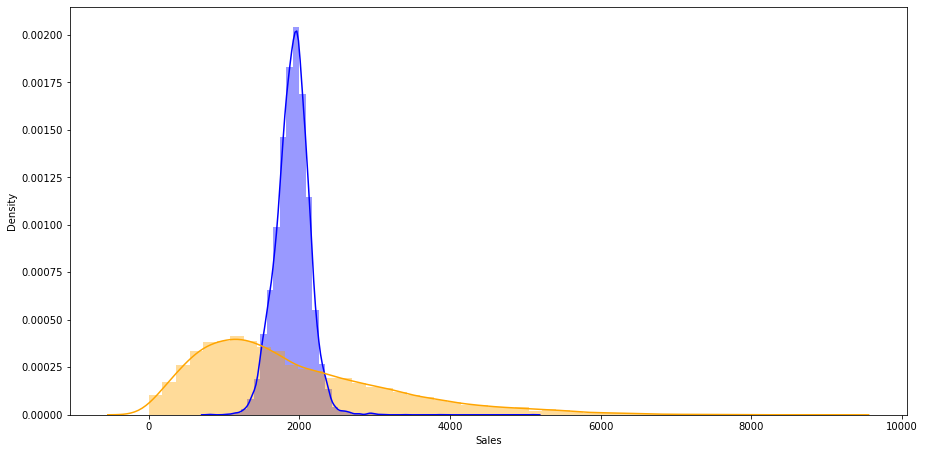

In [66]:
# Model initialization
model = xgboost.XGBRegressor() 
# Fit the data(train the model)
model.fit(train_X, train_y)
# Predict
y_predicted = model.predict(test_X)

# model evaluation
mse = mean_squared_error(test_y, y_predicted)
r2 = r2_score(test_y, y_predicted)

# printing values
#print('Slope:' ,regression_model.coef_)
#print('Intercept:', regression_model.intercept_)
print('Root Mean Squared Error: ', sqrt(mse)) 
print('R2 Score: ', r2)

#Plot actual vs predicted y values
y_pred=grid.predict(test_X)
plt.figure(figsize=(15,7.5))
sns.distplot(y_pred,color="Blue",label="Predicted")
sns.distplot(test_y,color="Orange",label="Actual")
plt.grid(False)

#Save the figure in a file
#plt.savefig(output_dir+"regression\\actual_predicted.png",bbox_inches='tight')    
plt.show() 
plt.close()

### Feature Importance - XGBoost

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


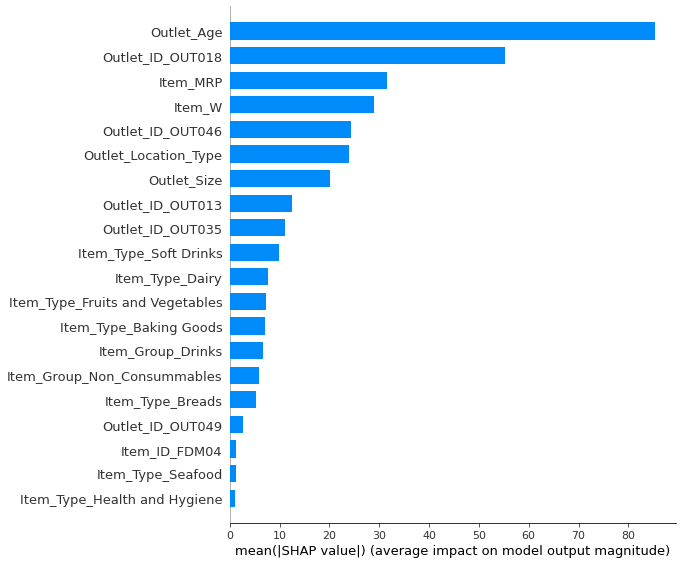

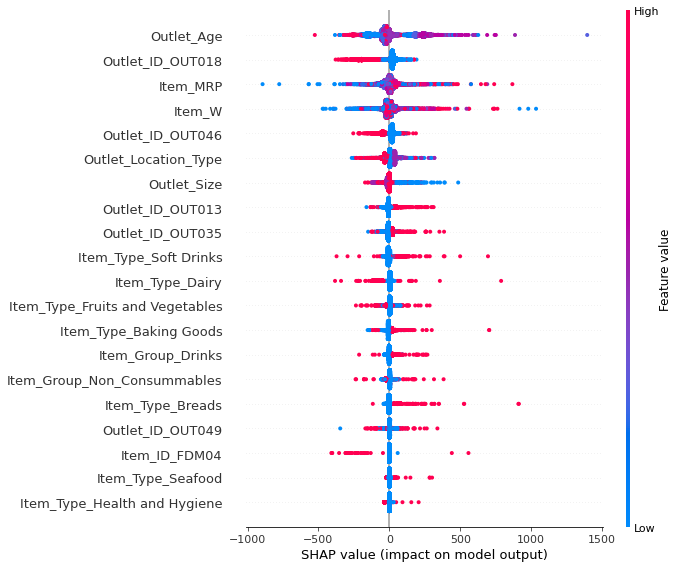

In [71]:
#The third method to compute feature importance in Xgboost is to use SHAP package. 
#It is model-agnostic and using the Shapley values from game theory to estimate the how does each feature contribute to the prediction.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X, plot_type="bar")
shap.summary_plot(shap_values, test_X)

### Hypertune XGBoost

In [72]:
# Hypertune XGBoost
# To improve, reduce max depth to 3, increase estimators to 1600 = 89.13%

model = xgboost.XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [0.01], 
              'max_depth': [5],
              'min_child_weight': [3],
              'subsample': [1],
              'colsample_bytree': [1], 
              'booster' : ['gbtree'],
              'n_estimators': [1500]} 

model = GridSearchCV(model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=False) 

In [ ]:
# Fit the data(train the model)
model.fit(train_X, train_y)
# Predict
y_predicted = model.predict(test_X)

# model evaluation
mse = mean_squared_error(test_y, y_predicted)
r2 = r2_score(test_y, y_predicted)

# printing values
#print('Slope:' ,regression_model.coef_)
#print('Intercept:', regression_model.intercept_)
print('Root Mean Squared Error: ', sqrt(mse)) 
print('R2 Score: ', r2)

#Plot actual vs predicted y values
y_pred=grid.predict(test_X)
plt.figure(figsize=(15,7.5))
sns.distplot(y_pred,color="Blue",label="Predicted")
sns.distplot(test_y,color="Orange",label="Actual")
plt.grid(False)

#Save the figure in a file
#plt.savefig(output_dir+"regression\\actual_predicted.png",bbox_inches='tight')    
plt.show() 
plt.close()

These ML models give us decent accuracy, but not great RMSE. We will need RMSE of around 1270 to get a rank in the leaderboard. Therefore, we will try ensemble modelling by stacking models.

### Stacked Ensemble Modelling - H2O

In [ ]:
#Convert pandas dataframe back to H2O frame
# Before applying H2O automl algorithms we have to convert the pandas dataframe into H2O readable format
# We do the data processing in pandas dataframe format because its faster to do so.

train = h2o.H2OFrame(train_as_df)
test = h2o.H2OFrame(test_as_df) 

In [49]:
# Identify predictors and response variables
# First,  identify predictors and response variables. Since we are predicting ‘Sales’ among datapoints so it will be the response variable. 
# The remaining variables in the dataframe will form the predictor variables.

x = train.columns
y = "Sales"
x.remove(y)

In [50]:
# Run AutoML for certain base models (limited to 1 hour max runtime by default)
# Default number of models is 10 and 1 hour is the default runtime.
# The ‘max_models’ argument specifies the number of individuals (or “base”) models and does not include any ensemble models that can be trained separately.
# However, through multiple iterations, I found that when model count is between 150-200 its gives the best RMSE
# Also, we can run this model on a Unix /Windows machine the difference being on a Windows machine the XGBoost model is not available, so we must run it on Ubuntu server

aml = H2OAutoML(max_models=max_models, seed=1) #max_runtime_secs, max_models
aml.train(x=x, y=y, training_frame=train)   

AutoML progress: |
22:47:20.458: AutoML: XGBoost is not available; skipping it.
22:47:20.523: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
22:47:20.523: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███ (cancelled)

22:47:44.619: Empty leaderboard.
AutoML was not able to build any model within a max runtime constraint of 0 seconds, you may want to increase this value before retrying.



H2OJobCancelled: Job<$03017f00000132d4ffffffff$_b2c57fdc75881b619a3f2cb74a2f4bea> was cancelled by the user.

### View the AutoML leaderboard

Next, we will view the AutoML Leaderboard. Since we did not specify a leaderboard_frame in the H2OAutoML.train() method for scoring and ranking the models, the AutoML leaderboard uses cross-validation metrics to rank the models.

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric. In the case of linear regression, the default ranking metric is RMSE(Root Mean Square Error). The leader model is stored at aml.leader and the leaderboard is stored at aml.leaderboard.

In [ ]:
# Here, we see that as per RMSE ranking the best model is "StackedEnsemble_Best1000_1_AutoML_4_20211107_64351"
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
# The leader model is stored here
# To view details about the best model, its performance metrics on cross-validated data

aml.leader

In [ ]:
# To generate predictions on a test set, you can make predictions
# directly on the `"H2OAutoML"` object or on the leader model
# object directly
#preds = aml.predict(test)
# or
preds = aml.leader.predict(test)

In [ ]:
preds.head(5)

In [ ]:
#Combine the prediction with the test dataset. Then we can view the Sales prediction of each outlet

df = test.cbind(preds)
df.head(5)
# Slice cols by vector of names
res = df[:, ["predict"]]
res.head(5)
#Rename column
res.set_names(['Sales']) 

### Save Prediction Results
    Save the results in a .CSV file. This is the submission file that is to be uploaded on the MachineHack website.

In [ ]:
# Export the file
#h2o.export_file(res, path = "C:\\Data_Science\\Competitions\\MachineHack-2021\\my_submission.csv", force = True)

# Convert to Pandas dataframe
# Save as .CSV file
res_as_df = h2o.as_list(res, use_pandas=True)
res_as_df.to_csv('C:\\Data_Science\\Competitions\\MachineHack-2021\\my_submissionFile.csv', index=False)

#### Save the model

There are two ways to save the leader model -- binary format and MOJO format. If you're taking your leader model to production, 
then we'd suggest the MOJO format since it's optimized for production use.

In [ ]:
h2o.save_model(aml.leader, path = "C:\\Data_Science\\Competitions\\MachineHack-2021\\h20_model_bin")

In [ ]:
aml.leader.download_mojo(path = "C:\\Data_Science\\Competitions\\MachineHack-2021")

### Ensemble Exploration

    To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model. The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run. This is often the top performing model on the leaderboard.

In [ ]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

Examine the variable importance of the metalearner (combiner) algorithm in the ensemble. This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM.

In [ ]:
metalearner.coef_norm()

In [ ]:
#We can also plot the base learner contributions to the ensemble.

%matplotlib inline
metalearner.std_coef_plot()